In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import numpy as np
import math

# open csv

In [2]:
# open preprocessed data
df = pd.read_csv('data/processed_reviews.csv')
without_dupe = df.drop_duplicates(subset=['review_text'], inplace=False)
# select subcategory to analyze
# subcategory = 'BODY CARE BODY LOTION'
subcategory = 'BODY CARE BODY LOTION'
label = "body_lotion"
df = df[df['subcategory'] == subcategory]
print(df.shape)
df.head()

(20281, 10)


,brand,product_title,proxy_date,retailer,category,subcategory,review_text,star_rating,topic,brand_type
210565,Palmer's,Palmer's Cocoa Butter Formula Daily Skin Thera...,2024-07-01,CVS,PERSONAL CARE,BODY CARE BODY LOTION,i have use this lotion for year and love it ve...,5.0,Moisturizer preference and usage habits,Competitor
210757,EOS,eos Shea Better Moisture Body Lotion - Vanilla...,2024-07-01,Target,PERSONAL CARE,BODY CARE BODY LOTION,ive be look for a new body lotion from a compa...,3.0,Positive reviews for a makeup remover (undeter...,Competitor
210829,Eucerin,Eucerin Intensive Repair Very Dry Skin Lotion ...,2024-07-01,Amazon,PERSONAL CARE,BODY CARE BODY LOTION,this lotion be a must have if you have dry ski...,5.0,Positive reviews for a makeup remover (undeter...,Competitor
210925,Medix 5.5,Medix 5.5 Retinol Body Lotion Firming Moisturi...,2024-07-01,Amazon,PERSONAL CARE,BODY CARE BODY LOTION,no retinol list on ingredient list,1.0,Positive reviews for a makeup remover (undeter...,Competitor
211032,Medix 5.5,Medix 5.5 Retinol Body Lotion Firming Moisturi...,2024-07-01,Amazon,PERSONAL CARE,BODY CARE BODY LOTION,i love this lotion lovely scent it have bright...,5.0,Positive reviews for a makeup remover (undeter...,Competitor


In [3]:
# group reviews by subcategory and make dictrionary with rating: review_text
grouped = df.groupby('star_rating').apply(lambda x: x['review_text'].tolist()).to_dict()

/var/folders/x2/lsyflj4j07jc1sb3w3hfgmjc0000gn/T/ipykernel_20563/719716116.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = df.groupby('star_rating').apply(lambda x: x['review_text'].tolist()).to_dict()


# LSA

In [4]:
# create lsa pipeline
def create_components(n_topics):
    vectorizer = TfidfVectorizer(stop_words='english', 
                                 use_idf=True, 
                                 ngram_range=(1, 3),
                                 smooth_idf=True)
    svd_model = TruncatedSVD(n_components=n_topics,        
                             algorithm='randomized',
                             n_iter=20)
    return vectorizer, svd_model

In [5]:
def get_number_topics(num_reviews):
    if num_reviews > 50000:
        return 20
    if num_reviews > 25000:
        return 15
    if num_reviews > 10000:
        return 10
    if num_reviews > 5000:
        return 8
    if num_reviews > 1000:
        return 6
    if num_reviews > 500:
        return 5
    if num_reviews > 100:
        return 4
    if num_reviews > 50:
        return 3
    if num_reviews > 10:
        return 2
    return 1
total_topics = get_number_topics(df.shape[0])
total_topics

10

In [6]:
def calculate_num_topics_star_rating(total_topics, star_rating, min_topics=1):
    # logarithmic weighting (smooth it out)
    weight = math.log(6 - star_rating + 1)  # Adding 1 to avoid log(0)


    # normalize weight to ensure sum of the topics is not greater than total_topics
    total_weight = sum(math.log(6 - r + 1) for r in range(1, 6))
    normalized_weight = weight / total_weight


    # number of topics for the group based on normalized weight
    num_topics = max(min_topics, math.ceil(normalized_weight * total_topics))


    return num_topics

total = df.shape[0]
# cur_num_topics = 0
# for i in range(1, 6):
#     print(f'num topics for rating {i} with {len(grouped[i])} reviews:')
#     print(calculate_num_topics(len(grouped[i]), total, total_topics, i))
#     cur_num_topics += calculate_num_topics(len(grouped[i]), total, total_topics, i)
# print(cur_num_topics)


In [7]:
num_topics_per_rating = {}
for i in range(1, 6):
    num_topics_per_rating[i] = calculate_num_topics_star_rating(total_topics, i)
    print(f'Rating {i} with {len(grouped[i])} reviews: {num_topics_per_rating[i]} topics')

Rating 1 with 1525 reviews: 3 topics
Rating 2 with 666 reviews: 3 topics
Rating 3 with 1059 reviews: 3 topics
Rating 4 with 2597 reviews: 2 topics
Rating 5 with 14434 reviews: 2 topics


In [8]:
# for each rating, fit the pipeline to the reviews and save results to lsa_df with columns: rating, topic_number, top_words, sample_reviews
lsa_df = pd.DataFrame(columns=['star_rating', 'review_text', 'lsa_topic_number', 'lsa_topic_words',])
# rating_topics = {} # dictionary to store topic vectors for each rating
rating_topics_top_words = {} # dictionary to store top words for each topic for each rating

for rating, reviews in grouped.items():
    n_topics = calculate_num_topics_star_rating(total_topics, rating)
    # if n_topics >= 2:
    vectorizer, svd_model = create_components(n_topics)
    X_tfidf = vectorizer.fit_transform(reviews)
    topic_matrix = svd_model.fit_transform(X_tfidf)
    terms = vectorizer.get_feature_names_out()
    
    topic_vectors = svd_model.components_
    # rating_topics[rating] = topic_vectors
    # Get the top words for each topic
    topic_words = {}
    for i in range(n_topics):
        top_word_indices = np.argsort(topic_vectors[i])  
        top_words = [terms[idx] for idx in top_word_indices[-15:]] # Top 15 words per topic
        topic_words[i] = top_words
    rating_topics_top_words[rating] = topic_words
    # For each review in the group, assign the most representative topic and top words
    for j, review in enumerate(reviews):
        most_representative_topic = np.argmax(topic_matrix[j])
        new_row = pd.DataFrame({
            'star_rating': [rating],
            'review_text': [review],
            'lsa_topic_number': [most_representative_topic],
            'lsa_topic_words': [', '.join(topic_words[most_representative_topic])]
        })
        lsa_df = pd.concat([lsa_df, new_row], ignore_index=True)

lsa_df

/var/folders/x2/lsyflj4j07jc1sb3w3hfgmjc0000gn/T/ipykernel_20563/3842249708.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  lsa_df = pd.concat([lsa_df, new_row], ignore_index=True)


KeyboardInterrupt: 

In [ ]:
rating_topics_top_words

{1.0: {0: ['bottle',
   'new formula',
   'scent',
   'buy',
   'year',
   'old',
   'change',
   'like',
   'product',
   'skin',
   'new',
   'lotion',
   'smell',
   'use',
   'formula'],
  1: ['return',
   'horrible smell',
   'strong',
   'dont',
   'lotion smell',
   'bottle',
   'smell horrible',
   'vanilla',
   'horrible',
   'scent',
   'pump',
   'lotion',
   'smell like',
   'like',
   'smell'],
  2: ['bottle',
   'make skin',
   'sensitive skin',
   'sensitive',
   'use',
   'face',
   'make',
   'lotion',
   'dry skin',
   'work',
   'break',
   'dry',
   'product',
   'pump',
   'skin']},
 2.0: {0: ['dry',
   'work',
   'formula',
   'just',
   'doesnt',
   'scent',
   'good',
   'moisturize',
   'product',
   'feel',
   'use',
   'like',
   'skin',
   'smell',
   'lotion'],
  1: ['strong',
   'good',
   'lotion smell',
   'sweet',
   'smell like vanilla',
   'like vanilla',
   'doesnt',
   'smell good',
   'scent',
   'doesnt smell like',
   'vanilla',
   'doesnt smell'

In [ ]:
# save lsa_df to csv
lsa_df.to_csv(f'outputs/lsa_{label}.csv', index=False)
lsa_df.shape

(20281, 4)

# generate phrases for each topic

In [ ]:
import os
from groq import Groq 

# Initialize the client
client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

# Define the system message
system_message = """
Generate a concise and coherent phrase that summarizes topics based on provided keywords
and associated review ratings. The keywords are ordered by relevance from the most to the least.

Ensure that each phrase accurately reflects the sentiment implied by the rating and highlights key aspects of the topic. 
For example, a rating of 1 should convey dissatisfaction or issues, while a rating of 5 should express satisfaction or positive feedback. 
Omit pronouns and conjunctions to keep the phrase succinct.

For reviews with low ratings (1-2) or with negative keywords, focus on problematic aspects such as defects, damages, or poor quality and 
be as detailed as possible.

Output only the phrase without additional commentary.

Example:

Input: "leak box, return, item, bottle leak, arrive damage, box, arrive, damage leak, damage, leak" Rating: 1
Output: "Leaking or damaged items and boxes upon delivery"
"""

def process_input(top_words, rating):
    user_message = f'Input: "{top_words}" rating: {rating}'
    response = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_message
            },
            {
                "role": "user",
                "content": user_message
            }
        ],
        model="llama3-8b-8192",
    )
    generated_phrase = response.choices[0].message.content
    return generated_phrase

topic_phrases = pd.DataFrame(columns=['star_rating', 'lsa_topic_number', 'lsa_topic_words', 'lsa_topic'])
# generate phrases for each topic in rating_topics_top_words
for rating, topics in rating_topics_top_words.items():
    for topic, top_words in topics.items():
        top_words = ', '.join(top_words)
        result = process_input(top_words, rating)
        new_row = pd.DataFrame({
            'star_rating': [rating],
            'lsa_topic_number': [topic],
            'lsa_topic_words': [top_words],
            'lsa_topic': [result]
        })
        topic_phrases = pd.concat([topic_phrases, new_row], ignore_index=True)
        print(f"Rating: {rating}, Topic: {topic}, Top Words: {top_words}")
        print(f"Generated phrase: {result}")
        print()

/var/folders/x2/lsyflj4j07jc1sb3w3hfgmjc0000gn/T/ipykernel_90424/3314073776.py:59: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  topic_phrases = pd.concat([topic_phrases, new_row], ignore_index=True)


Rating: 1.0, Topic: 0, Top Words: bottle, new formula, scent, buy, year, old, change, like, product, skin, new, lotion, smell, use, formula
Generated phrase: Outdated formula leading to unsatisfactory scent and skin reaction.

Rating: 1.0, Topic: 1, Top Words: return, horrible smell, strong, dont, lotion smell, bottle, smell horrible, vanilla, horrible, scent, pump, lotion, smell like, like, smell
Generated phrase: "Horrible strong scented lotion with undrinkable smell"

Rating: 1.0, Topic: 2, Top Words: bottle, make skin, sensitive skin, sensitive, use, face, make, lotion, dry skin, work, break, dry, product, pump, skin
Generated phrase: "Product causes skin irritation, dryness, and breakouts"

Rating: 2.0, Topic: 0, Top Words: dry, work, formula, just, doesnt, scent, good, moisturize, product, feel, use, like, skin, smell, lotion
Generated phrase: "Not moisturizing well, lacking good scent"

Rating: 2.0, Topic: 1, Top Words: strong, good, lotion smell, sweet, smell like vanilla, like

In [ ]:
# join with lsa_df
final_df = lsa_df.merge(topic_phrases, on=['star_rating', 'lsa_topic_number', 'lsa_topic_words'])

In [ ]:
# save lsa_df to csv
final_df.to_csv(f'outputs/lsa_{label}.csv', index=False)

## view generated phrases

In [ ]:
topic_phrases

,star_rating,lsa_topic_number,lsa_topic_words,lsa_topic
0,1.0,0,"bottle, new formula, scent, buy, year, old, ch...",Outdated formula leading to unsatisfactory sce...
1,1.0,1,"return, horrible smell, strong, dont, lotion s...","""Horrible strong scented lotion with undrinkab..."
2,1.0,2,"bottle, make skin, sensitive skin, sensitive, ...","""Product causes skin irritation, dryness, and ..."
3,2.0,0,"dry, work, formula, just, doesnt, scent, good,...","""Not moisturizing well, lacking good scent"""
4,2.0,1,"strong, good, lotion smell, sweet, smell like ...","""Does not meet expectations with lackluster sc..."
5,2.0,2,"leave, feel sticky, doesnt moisturize, feel li...","""Moisturizer doesn't provide adequate hydratio..."
6,3.0,0,"leave, doesnt, work, really, dry skin, scent, ...","""Product doesn't work well for dry skin, has p..."
7,3.0,1,"help dry skin, skin feel, oily skin, hydrate, ...","""Hydrates skin, leaving it balanced"""
8,3.0,2,"time, pump bottle, ive, open, pump work, break...","""Pump bottle works most of the time, but occas..."
9,4.0,0,"moisturize, scent, dry skin, love, really, sme...","""Moisturizes dry skin, great scent and feel"""


In [ ]:
# sample reviews and print generated phrases
for rating in final_df['star_rating'].unique():
    if rating > 3:
        break
    print(f"Rating: {rating}")
    for i, row in final_df[final_df['star_rating'] == rating].sample(5).iterrows():
        print(f"Topic: {row['lsa_topic_number']}, Top Words: {row['lsa_topic_words']}")
        print(f"Review: {row['review_text']}")
        print(f"Generated phrase: {row['lsa_topic']}")
        print()

Rating: 1.0
Topic: 0, Top Words: bottle, new formula, scent, buy, year, old, change, like, product, skin, new, lotion, smell, use, formula
Review: greasy oily and leave a sticky residue for far too long return and pick up shea moisture lotion much well
Generated phrase: Outdated formula leading to unsatisfactory scent and skin reaction.

Topic: 0, Top Words: bottle, new formula, scent, buy, year, old, change, like, product, skin, new, lotion, smell, use, formula
Review: this be possibly the bad lotion ive ever try it have the potential to be amaze but as i be rub it in it start pilling off everywhere all over my bed it be horrible i have to get in the shower and rinsescrub it all off so disappointed it sound wonderful i will return this sadly
Generated phrase: Outdated formula leading to unsatisfactory scent and skin reaction.

Topic: 0, Top Words: bottle, new formula, scent, buy, year, old, change, like, product, skin, new, lotion, smell, use, formula
Review: i use this lotion a lot i

## distribution of topics for each rating

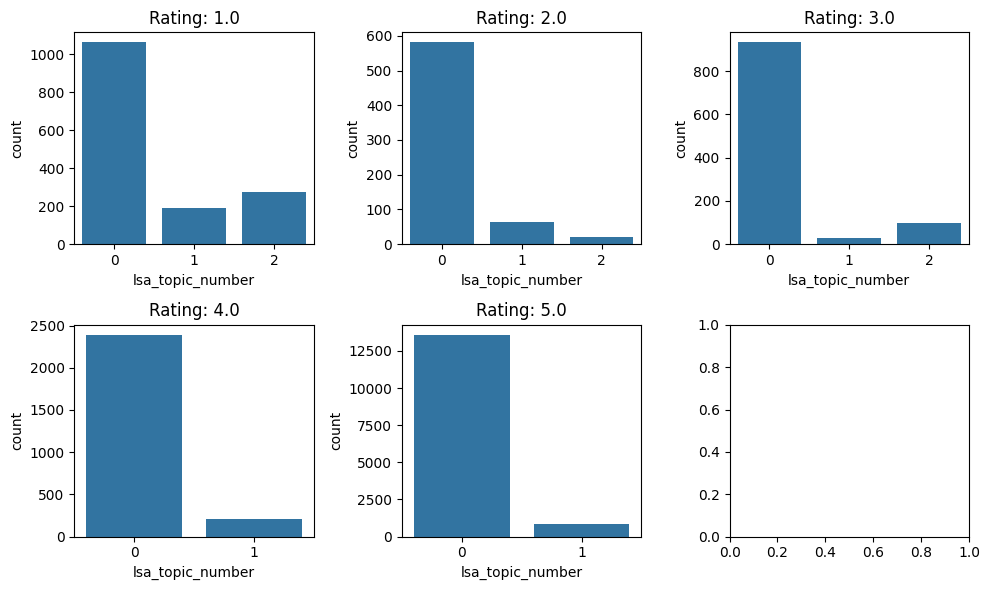

In [ ]:
# visualize distribution of topics, one plot per rating arranged in grid with 2 rows and 3 columns
import seaborn as sns
import matplotlib.pyplot as plt

# create grid of plots
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

for rating in final_df['star_rating'].unique():
    row = int((rating - 1) // 3)
    col = int((rating - 1) % 3)
    ax = axs[row][col]
    sns.countplot(data=final_df[final_df['star_rating'] == rating], x='lsa_topic_number', ax=ax)
    ax.set_title(f"Rating: {rating}")

# Display all subplots together
plt.tight_layout()
plt.show()

# evaluate quality of generated phrases

In [ ]:
# use sentence transformers to get similarity score between reviews and generated phrases
from sentence_transformers import SentenceTransformer
from torch.nn.functional import cosine_similarity

def similarity_scores(model_name, reviews, topics):
    """
    Calculate the similarity scores between reviews and topics using a pre-trained SentenceTransformer model.
    
    model_name: the name of the pre-trained SentenceTransformer model to use
    reviews: a list of review texts
    topics: a list of topic phrases
    
    return: a 2D numpy array of similarity scores
    """
    model = SentenceTransformer(model_name)
    review_embeddings = model.encode(reviews, convert_to_tensor=True)
    phrase_embeddings = model.encode(topics, convert_to_tensor=True)
    similarity_scores = cosine_similarity(review_embeddings, phrase_embeddings).cpu().numpy()
    return similarity_scores

In [ ]:
import time

model = 'all-MiniLM-L6-v2'
reviews = final_df['review_text'].tolist()
topics = final_df['lsa_topic'].tolist()
# run similarity_scores on chunks of reviews 
chunk_size = 1000
n = final_df.shape[0]
similarity_scores_list = []
for i in range(0, n, chunk_size):
    print(f'Processing reviews {i} to {min(i+chunk_size, n)}')
    start = time.time()
    similarity_scores_list.extend(similarity_scores(model, reviews[i:i+chunk_size], topics[i:i+chunk_size]))
    end = time.time()
    print(f"Time taken for {model}: {end - start}")

Processing reviews 0 to 1000


/Users/jessicaluo/Desktop/scrap/text_processes/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Time taken for all-MiniLM-L6-v2: 9.48236632347107
Processing reviews 1000 to 2000
Time taken for all-MiniLM-L6-v2: 7.1282758712768555
Processing reviews 2000 to 3000
Time taken for all-MiniLM-L6-v2: 6.267889738082886
Processing reviews 3000 to 4000
Time taken for all-MiniLM-L6-v2: 6.551764011383057
Processing reviews 4000 to 5000
Time taken for all-MiniLM-L6-v2: 5.705777168273926
Processing reviews 5000 to 6000
Time taken for all-MiniLM-L6-v2: 6.2053070068359375
Processing reviews 6000 to 7000
Time taken for all-MiniLM-L6-v2: 5.390501976013184
Processing reviews 7000 to 8000
Time taken for all-MiniLM-L6-v2: 4.9854960441589355
Processing reviews 8000 to 9000
Time taken for all-MiniLM-L6-v2: 5.136966228485107
Processing reviews 9000 to 10000
Time taken for all-MiniLM-L6-v2: 4.465231895446777
Processing reviews 10000 to 11000
Time taken for all-MiniLM-L6-v2: 4.181437253952026
Processing reviews 11000 to 12000
Time taken for all-MiniLM-L6-v2: 4.08484411239624
Processing reviews 12000 to 13

In [ ]:
final_df['similarity_score'] = similarity_scores_list

In [ ]:
# save final_df to csv
final_df.to_csv(f'outputs/lsa_{label}.csv', index=False)

In [ ]:
# print average similarity score for each rating/topic
print(final_df.groupby(['star_rating', 'lsa_topic_number'])['similarity_score'].mean())

star_rating  lsa_topic_number
1.0          0                   0.447943
             1                   0.463945
             2                   0.306810
2.0          0                   0.359094
             1                   0.335986
             2                   0.570615
3.0          0                   0.417431
             1                   0.348373
             2                   0.297584
4.0          0                   0.478119
             1                   0.391783
5.0          0                   0.410255
             1                   0.465901
Name: similarity_score, dtype: float32


### plot similarity score for each topic in each rating

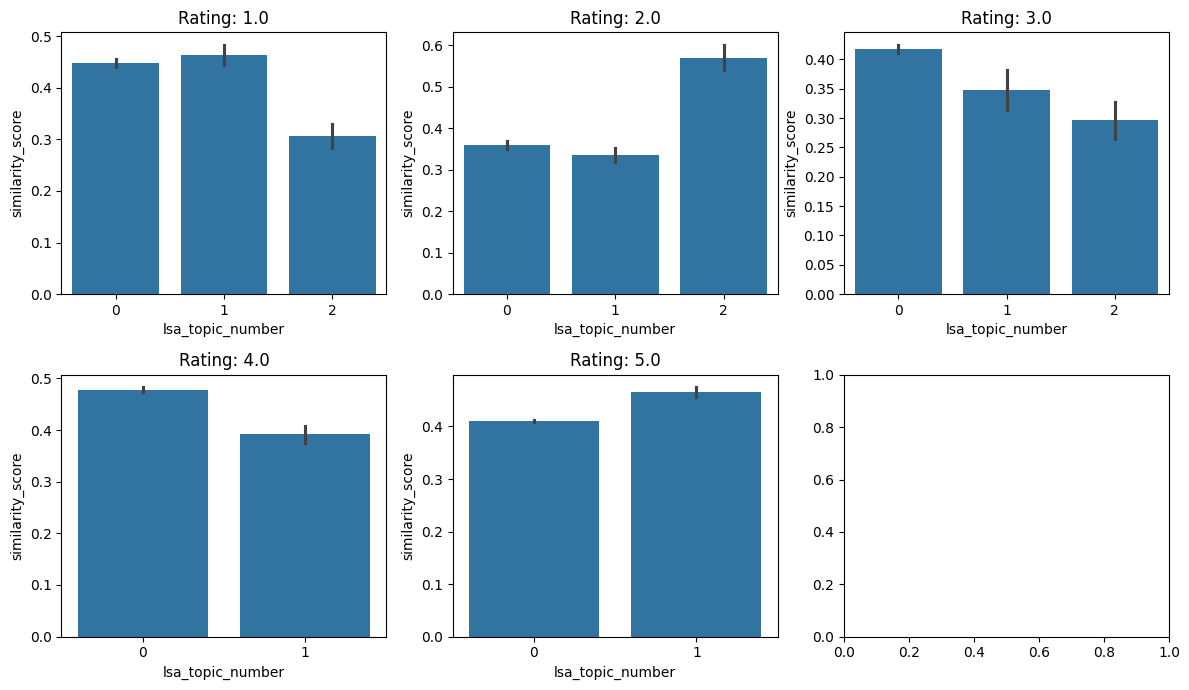

In [ ]:
# visualize average similarity scores for each rating/topic
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

for rating in final_df['star_rating'].unique():
    row = int((rating - 1) // 3)
    col = int((rating - 1) % 3)
    ax = axs[row][col]
    sns.barplot(data=final_df[final_df['star_rating'] == rating], x='lsa_topic_number', y='similarity_score', ax=ax)
    ax.set_title(f"Rating: {rating}")
plt.tight_layout()

### plot histogram of average similarity score across all reviews

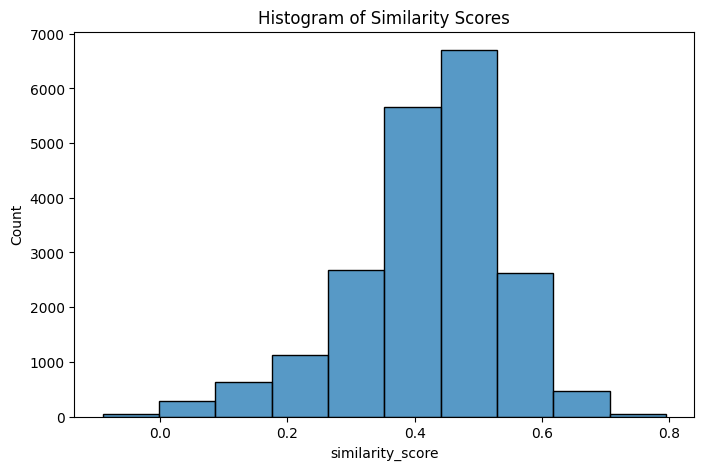

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(final_df['similarity_score'], bins=10)
plt.title("Histogram of Similarity Scores")
plt.show()

### plot a histograms of similarity score for each rating

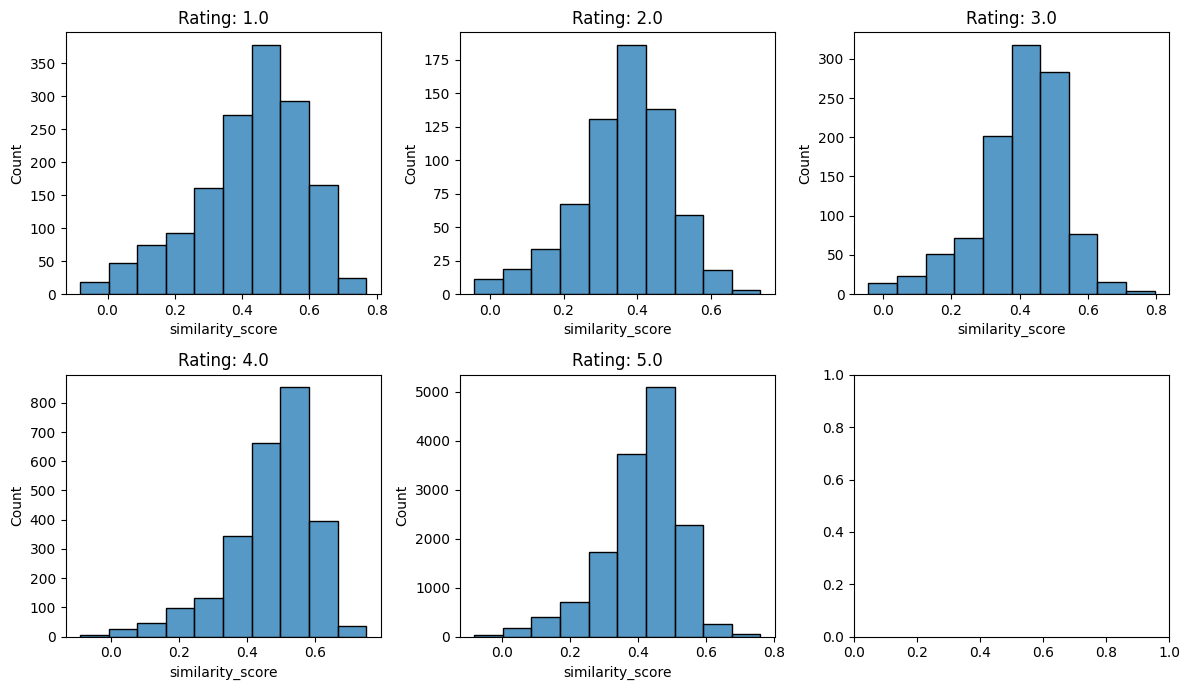

In [ ]:
# plot a histograms of average similarity score for each rating using grid of plots
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

for rating in final_df['star_rating'].unique():
    row = int((rating - 1) // 3)
    col = int((rating - 1) % 3)
    ax = axs[row][col]
    sns.histplot(final_df[final_df['star_rating'] == rating]['similarity_score'], bins=10, ax=ax)
    ax.set_title(f"Rating: {rating}")
plt.tight_layout()

In [ ]:
import TopicModel.LSA as lsa

lsa_model = lsa.LSA(model_name='lsa', df=df)

TypeError: module() takes at most 2 arguments (3 given)